In [1]:
import pyrealsense2 as rs
import numpy as np
import sys
import matplotlib.pyplot as plt
import cv2

sys.path.append("../")

from SurfaceContact.scene import extractBodyPixels, bodyCentroid
%load_ext autoreload
%autoreload 2


In [2]:
pipeline = rs.pipeline()
pipeline.start()


In [3]:
frames = pipeline.wait_for_frames()
rgb = frames.get_color_frame()
rgb_img = np.asanyarray(rgb.get_data())
depth = frames.get_depth_frame()
pc = rs.pointcloud()
points = pc.calculate(depth)
v = points.get_vertices()
verts = np.asanyarray(v).view(np.float32).reshape(-1, 3) 
verts = verts.reshape(rgb_img.shape)

depth_img = np.asanyarray(depth.get_data())

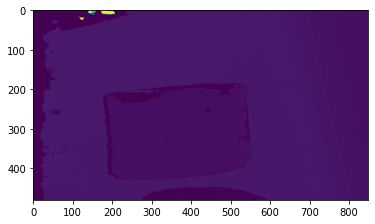

In [4]:
plt.imshow(depth_img)

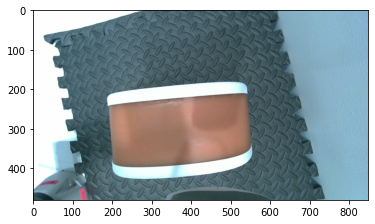

In [5]:
plt.imshow(rgb_img)

# Tune the rgb threshold of body pixel selection
Step 1: Use any  screencolor picker software to select body_color_rgb.

Step 2: Tune the hue radius of body_hsv_rad (the first element). Set body_hsv_rad = (x,50,50). Vary x from 0 to ~200. Pick the smallest x that visually includes most of the body pixels and no other pixels.

Step 3: Fixed the hue value obtained in step 2. Change the s and v radius so that maximal body pixels and minimal other pixels are picked up.


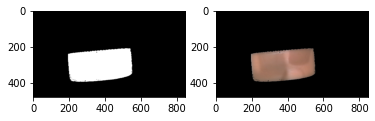

In [6]:
body_color_rgb = (227,124,100)
body_hsv_rad = (5,150,150)
scene = rgb_img

mask = extractBodyPixels(scene,body_color_rgb,body_hsv_rad)
result = cv2.bitwise_and(scene,scene,mask = mask)
plt.subplot(1,2,1)
plt.imshow(mask,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(result)
plt.show()

In [ ]:
# Compute the centroid 

In [8]:
centroid = bodyCentroid(mask)

# Compute the normal vector at the centroid of the body surface

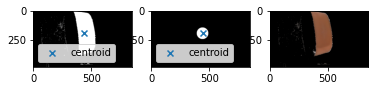

[0.04808978 1.9207047  1.3988711 ] [[-0.5675121  -0.81374055  0.12552397]
 [ 0.05447251  0.11501158  0.9918695 ]
 [ 0.82156116 -0.5697356   0.02094398]]


array([-0.5675121 ,  0.05447251,  0.82156116], dtype=float32)

In [70]:
from SurfaceContact.utils import patch_pixel_indx, normal_vector
patch_pixel_rad = 50

cx,cy = np.array(centroid,dtype=int)
h,w = mask.shape

patch_indx = patch_pixel_indx(cx,cy,h,w,patch_pixel_rad)
patch_mask = np.zeros(mask.shape)
for i,j in patch_indx:
    patch_mask[i,j] = mask[i,j]


plt.subplot(1,3,1)

plt.scatter(cx,cy,marker="x",label = 'centroid')
plt.legend()
plt.imshow(mask,cmap = 'gray')



plt.subplot(1,3,2)
plt.imshow(patch_mask,cmap = 'gray')
plt.scatter(cx,cy,marker="x",label = 'centroid')
plt.legend()

plt.subplot(1,3,3)
plt.imshow(result)

plt.show()
patch_verts = [verts[i,j] for i,j in patch_indx if np.any(verts[i,j])]
normal_vec = normal_vector(patch_verts)
normal_vec

In [34]:
normal_vec

array([-0.0028384 , -0.04772981,  0.99885625], dtype=float32)

In [11]:
pipeline.stop()